# Tensor construction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
import math
from scipy.interpolate import interp1d
import tlviz

## Import data

In [3]:
patients = []
for i in range(16):
    sheet_index = 2*i + 1
    file_path = 'TCR_seq_new.xlsx'
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    tcr_counts = tcr_df.filter(regex='Day').copy()

    tcr_counts.columns = [col.split('Day ')[1].strip() for col in tcr_counts.columns]
    tcr_counts = tcr_counts[sorted(tcr_counts.columns, key=lambda x: int(x))]
    tcr_counts = tcr_counts.where(~(tcr_counts.isna()), 0)
    matrix = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(100)
    patients.append(matrix)

In [4]:
# we delete 3 patients. Two of them for not having data pre treatment and one of them for not having enough data.
del patients[4] # SARK017. Not enough data.
del patients[7] # SARK011. No pre treatment data.
del patients[12] # SARK052. No pre treatment data.

## Interpolation

In [5]:
def interpolate_matrix(matrix, step=10):
    original_cols = np.array(matrix.columns, dtype=float)
    
    start = original_cols[0]
    end = original_cols[-1]
    target_end = math.trunc(end/10)*10
    
    target_columns = np.arange(start, target_end + step, step)
    
    matrix_values = matrix.values
    n_rows = matrix_values.shape[0]
    
    interpolated_matrix = np.zeros((n_rows, len(target_columns)))
    
    for i in range(n_rows):
        f = interp1d(original_cols, matrix_values[i], kind='linear', fill_value='extrapolate')
        interpolated_matrix[i] = f(target_columns)
    
    interpolated_df = pd.DataFrame(interpolated_matrix, index=matrix.index, columns=target_columns)
    
    return interpolated_df

In [6]:
interp_patients = []
for i in patients:
    interp_patients.append(interpolate_matrix(i))

## Joining matrices

In [7]:
# We take the patients with sufficient amount of data for each tensor (70, 100, 200, 300 days)
patients_70 = []
patients_100 = []
patients_200 = []
patients_300 = []
for i in interp_patients:
    if i.columns[-1] >= 70:
        patients_70.append(i)
    if i.columns[-1] >= 100:
        patients_100.append(i)
    if i.columns[-1] >= 200:
        patients_200.append(i)
    if i.columns[-1] >= 300:
        patients_300.append(i)

In [8]:
# we select only the desired columns for each tensor (8, 11, 21, 31)
for i in range(len(patients_70)):
    patients_70[i] = patients_70[i].loc[:, patients_70[i].columns <= 70]
for i in range(len(patients_100)):
    patients_100[i] = patients_100[i].loc[:, patients_100[i].columns <= 100]
for i in range(len(patients_200)):
    patients_200[i] = patients_200[i].loc[:, patients_200[i].columns <= 200]
for i in range(len(patients_300)):
    patients_300[i] = patients_300[i].loc[:, patients_300[i].columns <= 300]

In [19]:
# we join the matrices to obtain the desired tensors
tensor_70 = np.stack(patients_70, axis=-1)
tensor_100 = np.stack(patients_100, axis=-1)
tensor_200 = np.stack(patients_200, axis=-1)
tensor_300 = np.stack(patients_300, axis=-1)

In [20]:
print(tensor_70.shape) # 8 time steps, 13 patients
print(tensor_100.shape) # 11 time steps, 11 patients
print(tensor_200.shape) # 21 time steps, 9 patients
print(tensor_300.shape) # 31 time steps, 6 patients

(100, 8, 13)
(100, 11, 11)
(100, 21, 9)
(100, 31, 6)


## Normalization into 0-1 scale

In [11]:
def norm_01scale(tensor):
    sum_mode_0 = np.sum(tensor, axis=0, keepdims=True)
    sum_mode_0[sum_mode_0 == 0] = 1
    return tensor / sum_mode_0

In [12]:
tensor_70_norm = norm_01scale(tensor_70)
tensor_100_norm = norm_01scale(tensor_100)
tensor_200_norm = norm_01scale(tensor_200)
tensor_300_norm = norm_01scale(tensor_300)

## Scaling

In [274]:
def scaling(tensor, mode, mode1, mode2):
    scale_factors = 1 / np.sqrt(np.sum(tensor**2 , axis=(mode1, mode2)))

    shape = [1] * tensor.ndim
    shape[mode] = tensor.shape[mode]
    scale_factors = scale_factors.reshape(shape)
    
    return tensor * scale_factors

In [324]:
tensor_70_scaled = scaling(tensor_70, 2, 0, 1)
tensor_100_scaled = scaling(tensor_100, 2, 0, 1)
tensor_200_scaled = scaling(tensor_200, 2, 0, 1)
tensor_300_scaled = scaling(tensor_300, 2, 0, 1)

## Centering

In [13]:
def centering(tensor, mode):
    mean = np.mean(tensor, axis=mode, keepdims=True)
    return tensor - mean

In [21]:
tensor_70_cent = centering(tensor_70, 1)
tensor_100_cent = centering(tensor_100, 1)
tensor_200_cent = centering(tensor_200, 1)
tensor_300_cent = centering(tensor_300, 1)

## Saving

In [175]:
# we save the tensors in numpy format
np.save('tensors/tensor_70.npy', tensor_70)
np.save('tensors/tensor_100.npy', tensor_100)
np.save('tensors/tensor_200.npy', tensor_200)
np.save('tensors/tensor_300.npy', tensor_300)
np.save('tensors_log/tensor_70.npy', tensor_70_log)
np.save('tensors_log/tensor_100.npy', tensor_100_log)
np.save('tensors_log/tensor_200.npy', tensor_200_log)
np.save('tensors_log/tensor_300.npy', tensor_300_log)

In [22]:
np.save('tensors_center/tensor_70.npy', tensor_70_cent)
np.save('tensors_center/tensor_100.npy', tensor_100_cent)
np.save('tensors_center/tensor_200.npy', tensor_200_cent)
np.save('tensors_center/tensor_300.npy', tensor_300_cent)

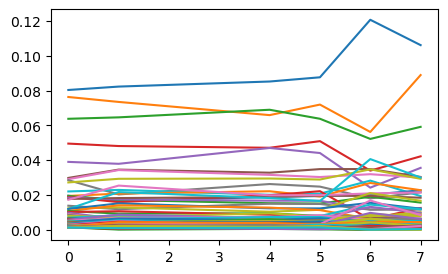

In [17]:
tensor = tensor_70
patient = 12
t = np.arange(len(tensor[0,:,0]))

plt.figure(figsize=(5, 3))
for i in range(100):
    plt.plot(t, tensor[i, :, patient])
plt.show()